# Deep Learning Model Training for Customer Sentiment Analysis


In this walkthrough, you will train and fine-tune a deep learning model to analyze customer feedback and provide actionable insights.

**Scenario:**
Your retail client needs a sentiment analysis model to categorize customer reviews as positive, neutral, or negative and identify trends to enhance their strategy.

**Objective:**
- Preprocess a synthetic dataset of customer reviews for model training.
- Train a sentiment analysis model using an LSTM or fine-tune a pre-trained transformer like BERT.
- Measure accuracy, F1-score, and confusion matrix; identify areas for improvement.
- Deliver a brief summary of key trends, model performance, and recommendations (e.g., addressing delivery complaints).
- Discuss how to explain findings and next steps to a non-technical client.




### Part 1: Load the 'product_reviews.csv' dataset into a pandas Dataframe
**Task 1:**
- Load and Preprocess the dataset.
- Perform EDA to understand patterns in the dataset
- Data Preprocessing
- Split the dataset into training and testing datasets

In [1]:
import pandas as pd
data=pd.read_csv('../data/prod_reviews.csv')
data.head(10)

Review Sentiment
0  This product exceeded my expectations! It's hi...  Positive
1  The product was decent. It worked fine, but it...   Neutral
2  I had a terrible experience with this company....  Negative
3  It's an okay product. Nothing to write home ab...   Neutral
4  Disappointed with the product. It didn't meet ...  Negative
5  Avoid this company at all costs. The service i...  Negative
6  I had a terrible experience with this company....  Negative
7  Avoid this company at all costs. The service i...  Negative
8  This product exceeded my expectations! It's hi...  Positive
9  This product is outstanding! It's exactly what...  Positive

### Exploratory Data Analysis

In [2]:
data.describe()

Review Sentiment
count                                                 395       395
unique                                                140         3
top     This product exceeded my expectations! It's hi...  Positive
freq                                                   22       138

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     395 non-null    object
 1   Sentiment  395 non-null    object
dtypes: object(2)
memory usage: 6.3+ KB


In [4]:
data["Sentiment"].value_counts()

Positive    138
Negative    129
Neutral     128
Name: Sentiment, dtype: int64

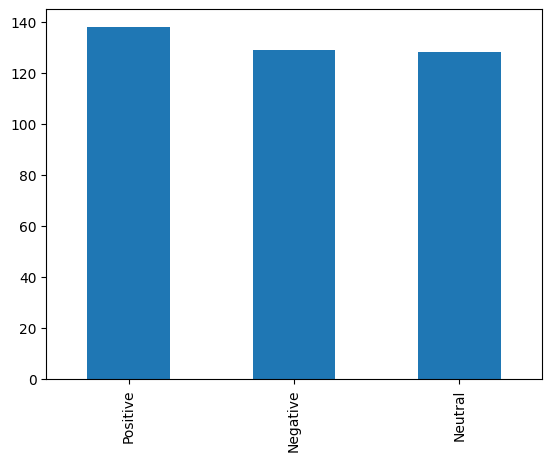

In [5]:
import matplotlib.pyplot as plt 
data["Sentiment"].value_counts().plot(kind='bar')
plt.show()

In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tensorflow as tf

from sklearn.model_selection import train_test_split
import sklearn

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# downloading punkt sentence tokenizer models
nltk.download('punkt')
# downloading stopwords from nltk library
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Review text Cleaning
def clean_reviews(text):
    
    # removing html brackets and other square brackets from the string using regex
    regex = re.compile('<.*?>') # r'<.*?>'
    text = re.sub(regex, '', text)

    # removing special characters like @, #, $, etc
    pattern = re.compile('[^a-zA-z0-9\s]')
    text = re.sub(pattern,'',text)

    # removing numbers
    pattern = re.compile('\d+')
    text = re.sub(pattern,'',text)

    # converting text to lower case
    text = text.lower()
    
    # Tokenization of words
    text = word_tokenize(text)
    
    # Stop words removal
    text = [word for word in text if not word in stop_words]
    
    return text

2025-02-04 13:08:18.706916: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-04 13:08:18.954079: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-02-04 13:08:18.954119: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-02-04 13:08:20.649931: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

In [7]:
# using the clean_reviews function on the dataset
data['Review'] = data['Review'].apply(clean_reviews)

In [8]:
# Step 1: Data Preprocessing
# Extract reviews and sentiments
reviews = data['Review'].values
sentiments = data['Sentiment'].values

# Encode sentiment labels into integers
sentiment_labels = {'Positive': 0, 'Neutral': 1, 'Negative': 2}
sentiments_encoded = [sentiment_labels[sentiment] for sentiment in sentiments]

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(reviews, sentiments_encoded, test_size=0.2, random_state=42)

# Tokenize the reviews
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# Pad sequences
max_length = 100
x_train_padded = pad_sequences(x_train_seq, maxlen=max_length, padding='post', truncating='post')
x_test_padded = pad_sequences(x_test_seq, maxlen=max_length, padding='post', truncating='post')

# Convert labels to categorical (one-hot encoding)
y_train_categorical = to_categorical(y_train, num_classes=3)
y_test_categorical = to_categorical(y_test, num_classes=3)

### Part 2: Build Model to train a sentiment analysis using an LSTM
**Task:**
- Model Building and Compiling

In [9]:
# Step 2: Build the LSTM Model
model = Sequential(name="LSTM_Sentiment_Analysis")
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_length))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 3: Train the Model
history = model.fit(x_train_padded, y_train_categorical, epochs=5, batch_size=32, validation_data=(x_test_padded, y_test_categorical))

# Step 4: Evaluate the Model
loss, accuracy = model.evaluate(x_test_padded, y_test_categorical)
loss, accuracy


2025-02-04 13:08:22.310236: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-02-04 13:08:22.310272: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2025-02-04 13:08:22.310293: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (a-1nknwnm42hqwe): /proc/driver/nvidia/version does not exist
2025-02-04 13:08:22.310643: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5
10/10 [==============================] - 8s 333ms/step - loss: 1.1029 - accuracy: 0.3038 - val_loss: 1.0979 - val_accuracy: 0.3671
Epoch 2/5
10/10 [==============================] - 2s 217ms/step - loss: 1.1011 - accuracy: 0.3576 - val_loss: 1.0966 - val_accuracy: 0.3671
Epoch 3/5
10/10 [==============================] - 2s 204ms/step - loss: 1.1050 - accuracy: 0.2911 - val_loss: 1.0982 - val_accuracy: 0.3291
Epoch 4/5
10/10 [==============================] - 2s 230ms/step - loss: 1.1013 - accuracy: 0.3323 - val_loss: 1.0972 - val_accuracy: 0.3671
Epoch 5/5
3/3 [==============================] - 0s 64ms/step - loss: 1.0979 - accuracy: 0.3671


(1.097891926765442, 0.3670886158943176)

### Part 3: Evaluating Model 

**Task:**
- Evaluating the Model using metrics like precision, recall, and F1-score

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on the test set
y_pred = model.predict(x_test_padded)  # Probabilities for each class
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true_labels = np.argmax(y_test_categorical, axis=1)  # True labels from one-hot encoding

# Generate Classification Report
print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=list(sentiment_labels.keys())))

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(sentiment_labels.keys()), yticklabels=list(sentiment_labels.keys()))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


ModuleNotFoundError: No module named 'seaborn'